/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Processing scenario: historical
  Calculating PSD for Truth...
  Truth PSD calculated successfully
  Calculating PSD for Bilinear...
  Bilinear PSD calculated successfully
  Calculating PSD for QDM...
  QDM PSD calculated successfully
  Calculating PSD for MLd...
  MLd PSD calculated successfully
  Calculating PSD for MLs...
  MLs PSD calculated successfully
Processing scenario: ssp126
  Calculating PSD for Truth...
  Truth PSD calculated successfully
  Calculating PSD for Bilinear...
  Bilinear PSD calculated successfully
  Calculating PSD for QDM...
  QDM PSD calculated successfully
  Calculating PSD for MLd...
  MLd PSD calculated successfully
  Calculating PSD for MLs...
  MLs PSD calculated successfully
Processing scenario: ssp245
  Calculating PSD for Truth...
  Truth PSD calculated successfully
  Calculating PSD for Bilinear...
  Bilinear PSD calculated successfully
  Calculating PSD for QDM...
  QDM PSD calculated successfully
  Calculating PSD for MLd...
  MLd PSD calculated s

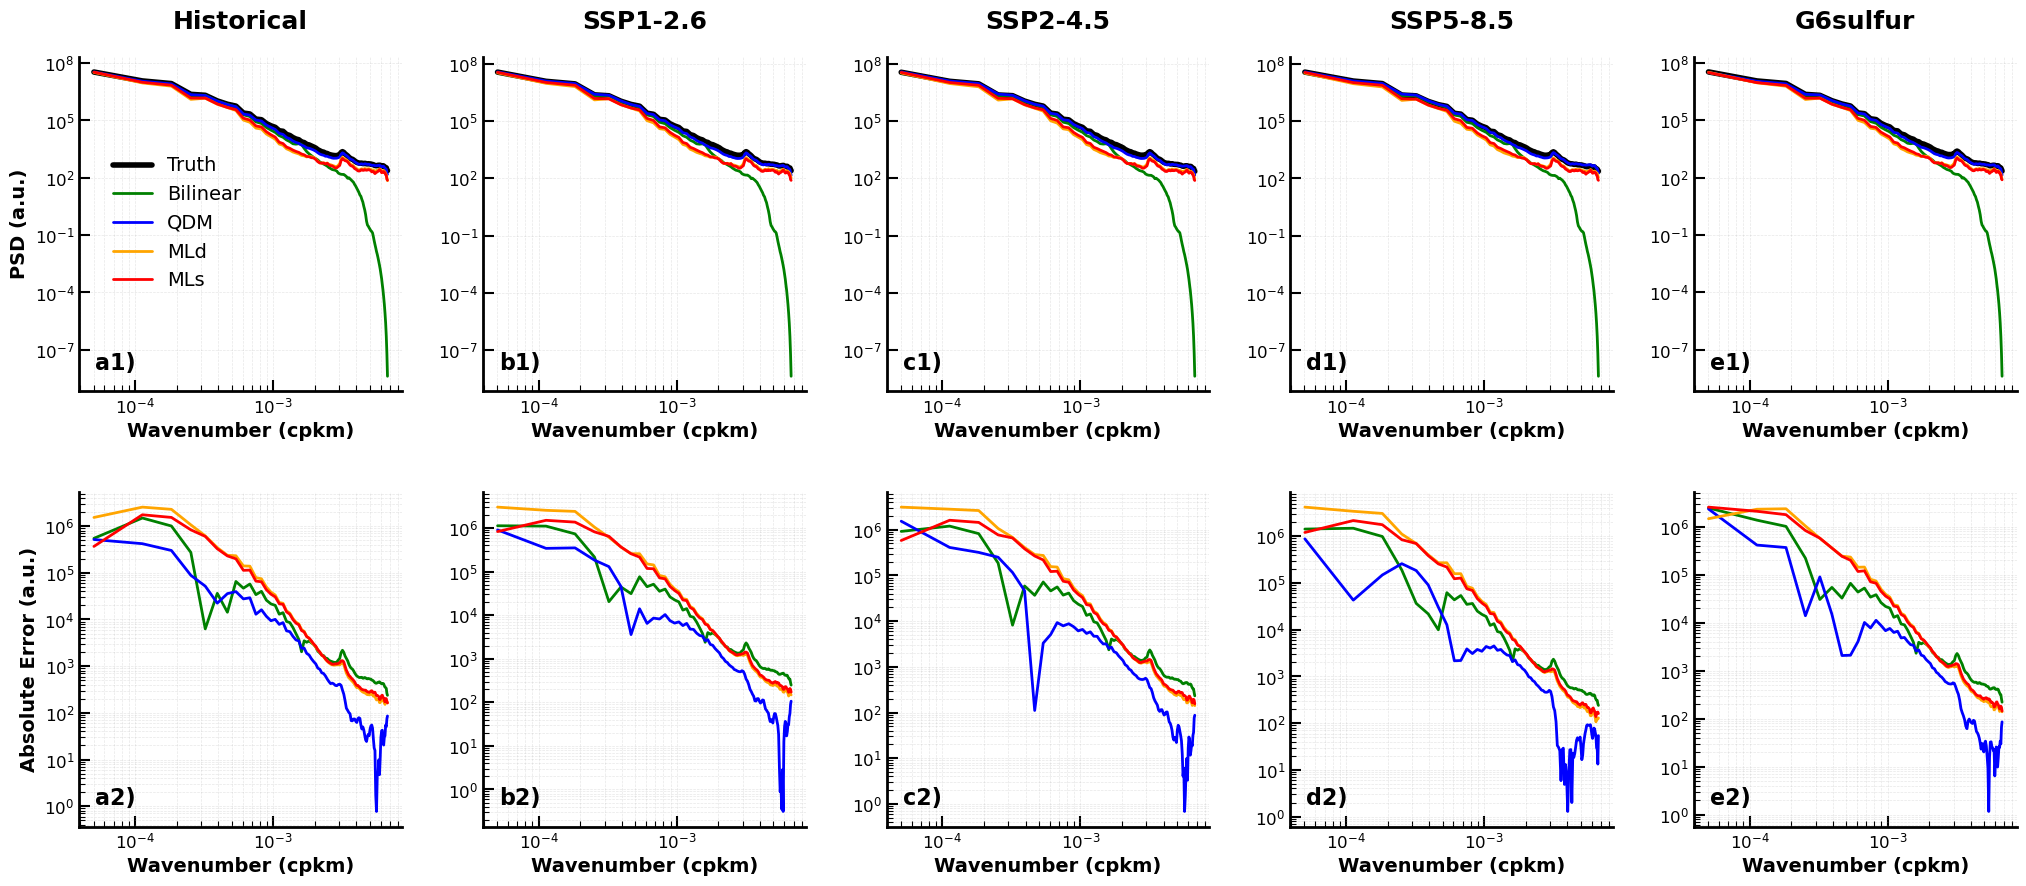

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']

scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'g6sulfur': 'G6sulfur',
    'ssp585': 'SSP5-8.5'
}

# Models to compare
models = {
    'groundtruth': 'Truth',
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# Colors for each model
model_colors = {
    'groundtruth': 'black',
    'bilinear': 'green',    
    'qdm': 'blue',         
    'mld': 'orange',         
    'mls': 'red'         
}

# Line widths
model_linewidths = {
    'groundtruth': 4.0,
    'bilinear': 2.0,
    'qdm': 2.0,
    'mld': 2.0,
    'mls': 2.0
}

# Alpha values
model_alphas = {
    'groundtruth': 1.0,
    'bilinear': 1.0,
    'qdm': 1.0,
    'mld': 1.0,
    'mls': 1.0
}

# Spatial resolution: 0.94 degrees * 111 km/degree
dx_km = 0.94 * 111  # approximately 104.34 km

# ----------------------------
# Functions
# ----------------------------
def isotropic_spectra(data):
    """Calculate the isotropic power spectrum by radially averaging 2D power spectrum."""
    # Calculate 2D power spectrum
    ps_2d = xrft.power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True
    )
    
    # Get frequency coordinates
    freq_i = ps_2d.freq_i.values
    freq_j = ps_2d.freq_j.values
    
    # Create 2D frequency magnitude grid
    freq_i_grid, freq_j_grid = np.meshgrid(freq_i, freq_j, indexing='ij')
    freq_r = np.sqrt(freq_i_grid**2 + freq_j_grid**2)
    
    # Radially average
    freq_r_flat = freq_r.flatten()
    ps_flat = ps_2d.values.flatten()
    
    # Create bins for radial averaging
    n_bins = min(len(freq_i), len(freq_j)) // 2
    bins = np.linspace(freq_r_flat.min(), freq_r_flat.max(), n_bins)
    
    # Bin the data
    digitized = np.digitize(freq_r_flat, bins)
    
    # Compute mean PSD in each bin
    bin_means = []
    bin_freqs = []
    for i in range(1, len(bins)):
        mask = digitized == i
        if np.any(mask):
            bin_means.append(np.mean(ps_flat[mask]))
            bin_freqs.append(np.mean(freq_r_flat[mask]))
    
    # Create output as xarray
    result = xr.DataArray(
        bin_means,
        dims=['freq_r'],
        coords={'freq_r': bin_freqs}
    )
    
    return result

def calculate_psd_km(field, dx=104.34):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)

def transform_to_numeric_coords(data_array):
    """Transform lat/lon/time coordinates to simple numeric i/j/time coordinates."""
    n_time, n_lat, n_lon = data_array.shape
    
    # Create simple numeric coordinates
    time_coords = np.arange(n_time)
    i_coords = np.arange(n_lat)
    j_coords = np.arange(n_lon)
    
    # Create xarray DataArray with numeric coordinates
    da = xr.DataArray(
        data_array,
        dims=['time', 'i', 'j'],
        coords={
            'time': time_coords,
            'i': i_coords,
            'j': j_coords
        }
    )
    
    return da

def calculate_mean_psd_over_time(data_array, dx=104.34):
    """Calculate mean PSD averaged over all time slices."""
    # Transform to numeric coordinates
    da = transform_to_numeric_coords(data_array)
    
    n_time = da.sizes['time']
    psd_list = []
    
    # Calculate PSD for each time slice
    for t in range(n_time):
        field_2d = da.isel(time=t).values
        
        # Skip if all NaN
        if np.all(np.isnan(field_2d)):
            continue
        
        try:
            # Calculate PSD for this time slice
            psd = calculate_psd_km(field_2d, dx=dx)
            psd_list.append(psd.values)
        except Exception as e:
            print(f"Warning: PSD calculation failed for time {t}: {e}")
            continue
    
    if len(psd_list) == 0:
        raise ValueError("No valid PSD calculations")
    
    # Average over all time slices
    mean_psd = np.nanmean(psd_list, axis=0)
    
    # Get wavenumbers from the last successful PSD calculation
    wavenumbers = psd.freq_r.values
    
    return mean_psd, wavenumbers

def load_model_data(scenario):
    """Load all model data for precipitation and given scenario"""
    data_dict = {}
    
    # Load main results (groundtruth, bilinear, MLd)
    main_file = results_dir / f"pr_evaluation_{scenario}.nc"
    if main_file.exists():
        ds_main = xr.open_dataset(main_file)
        
        # Ground truth
        if 'groundtruth' in ds_main:
            data_dict['groundtruth'] = ds_main['groundtruth'].values
        
        # Bilinear (input)
        if 'input' in ds_main:
            data_dict['bilinear'] = ds_main['input'].values
        
        # MLd (zscore_pixel)
        if 'pred_zscore_pixel' in ds_main:
            data_dict['mld'] = ds_main['pred_zscore_pixel'].values
        
        ds_main.close()
    
    # Load QDM results
    qdm_file = results_dir / f"pr_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        
        if 'pred_qdm' in ds_qdm:
            data_dict['qdm'] = ds_qdm['pred_qdm'].values
        
        ds_qdm.close()
    
    # Load residual results (MLs = PLD-Res)
    residual_file = results_residual_dir / f"pr_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        
        if 'pred_grid' in ds_residual:
            data_dict['mls'] = ds_residual['pred_grid'].values
        
        ds_residual.close()
    
    return data_dict

# ----------------------------
# Create 2x5 subplot figure
# ----------------------------
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Panel labels
panel_labels = [
    ['a1)', 'b1)', 'c1)', 'd1)', 'e1)'],  # Row 1: PSD
    ['a2)', 'b2)', 'c2)', 'd2)', 'e2)']   # Row 2: PSD error
]

for col, scenario in enumerate(scenarios):
    print(f"Processing scenario: {scenario}")
    
    # Load data for this scenario
    data_dict = load_model_data(scenario)
    
    # Store PSDs for error calculation
    psds = {}
    wavenumbers = None
    
    # --- PSD ROW (Row 0) ---
    ax_psd = axes[0, col]
    
    # Calculate and plot PSD for each model
    for model_key, model_label in models.items():
        if model_key not in data_dict:
            print(f"  Skipping {model_label} - data not found")
            continue
        
        print(f"  Calculating PSD for {model_label}...")
        
        try:
            # Calculate mean PSD over time
            mean_psd, wavenum = calculate_mean_psd_over_time(
                data_dict[model_key], 
                dx=dx_km
            )
            
            psds[model_key] = mean_psd
            if wavenumbers is None:
                wavenumbers = wavenum
            
            # Plot
            ax_psd.loglog(wavenumbers, mean_psd,
                         color=model_colors[model_key],
                         linewidth=model_linewidths[model_key],
                         alpha=model_alphas[model_key],
                         label=model_label,
                         solid_capstyle='round')
            
            print(f"  {model_label} PSD calculated successfully")
            
        except Exception as e:
            print(f"  Error calculating PSD for {model_label}: {e}")
            continue
    
    # Add panel label for PSD row
    ax_psd.text(0.05, 0.05, panel_labels[0][col],
               transform=ax_psd.transAxes,
               fontsize=16, fontweight='bold',
               va='bottom', ha='left')
    
    # Format PSD axis
    ax_psd.tick_params(axis='both', which='major', labelsize=12, length=8, 
                       width=1.5, direction='in')
    ax_psd.tick_params(axis='both', which='minor', length=4, 
                       width=0.8, direction='in')
    
    # Labels for PSD row
    ax_psd.set_xlabel(r'Wavenumber (cpkm)', fontsize=14, fontweight='bold')
    
    # Y-axis label (only on first panel)
    if col == 0:
        ax_psd.set_ylabel(r'PSD (a.u.)', fontsize=14, fontweight='bold')
    
    # Title (only on top row)
    ax_psd.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=20)
    
    # Legend (only on first panel)
    if col == 0:
        ax_psd.legend(loc='lower left', bbox_to_anchor=(0.05, 0.25), 
                     fontsize=14, frameon=False, handlelength=2)
    
    # Formatting for PSD
    ax_psd.spines['top'].set_visible(False)
    ax_psd.spines['right'].set_visible(False)
    ax_psd.spines['left'].set_linewidth(2)
    ax_psd.spines['bottom'].set_linewidth(2)
    ax_psd.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, which='both')
    
    # --- ERROR ROW (Row 1) ---
    ax_error = axes[1, col]
    
    # Plot absolute errors relative to Truth
    if 'groundtruth' in psds and wavenumbers is not None:
        truth_psd = psds['groundtruth']
        
        for model_key, model_label in models.items():
            if model_key == 'groundtruth' or model_key not in psds:
                continue
            
            # Compute absolute error
            abs_error = np.abs(psds[model_key] - truth_psd)
            
            # Plot error
            ax_error.loglog(wavenumbers, abs_error,
                           color=model_colors[model_key],
                           linewidth=model_linewidths[model_key],
                           alpha=model_alphas[model_key],
                           label=model_label,
                           solid_capstyle='round')
    
    # Add panel label for error row
    ax_error.text(0.05, 0.05, panel_labels[1][col],
                 transform=ax_error.transAxes,
                 fontsize=16, fontweight='bold',
                 va='bottom', ha='left')
    
    # Format error axis
    ax_error.tick_params(axis='both', which='major', labelsize=12, length=8, 
                         width=1.5, direction='in')
    ax_error.tick_params(axis='both', which='minor', length=4, 
                         width=0.8, direction='in')
    
    # Labels for error row
    ax_error.set_xlabel(r'Wavenumber (cpkm)', fontsize=14, fontweight='bold')
    
    # Y-axis label (only on first panel)
    if col == 0:
        ax_error.set_ylabel(r'Absolute Error (a.u.)', fontsize=14, fontweight='bold')
    
    # Formatting for error
    ax_error.spines['top'].set_visible(False)
    ax_error.spines['right'].set_visible(False)
    ax_error.spines['left'].set_linewidth(2)
    ax_error.spines['bottom'].set_linewidth(2)
    ax_error.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, which='both')

plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Save figure
output_file = figures_dir / "fig9.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()